<a href="https://colab.research.google.com/github/Taufik-png/Scraping-dan-Analisis-Sentimen-Menteri-Purbaya-/blob/main/Data_Cleaning_dan_Analisis_Sentimen_Menteri_Purbaya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Cleaning and Processing

In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime

In [2]:
# Load the data
df = pd.read_csv('Menteri_Purbaya.csv')

In [3]:
# Initial data inspection
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
df.head()

Dataset shape: (1110, 15)

First few rows:


,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1976436926501781723,Thu Oct 09 23:57:38 +0000 2025,1,Statemen prof MMD ini yang kami tunggu2 setela...,1976436926501781723,NaN,NaN,in,NaN,0,1,0,https://x.com/undefined/status/197643692650178...,1265262339537858560,NaN
1,1976314941704634840,Thu Oct 09 23:54:57 +0000 2025,0,@kompascom Kan dah dibilangin mentri sekarang ...,1976436253815079067,NaN,kompascom,in,NaN,0,0,0,https://x.com/undefined/status/197643625381507...,4766450011,NaN
2,1976435680449552428,Thu Oct 09 23:52:41 +0000 2025,2,Semoga Purbaya bukan pura-pura berbahaya. Mema...,1976435680449552428,NaN,NaN,in,NaN,0,0,2,https://x.com/undefined/status/197643568044955...,213168371,NaN
3,1976408718469366274,Thu Oct 09 23:43:25 +0000 2025,1,@Naz_lira Kebijakan pak Purbaya jelas kebijaka...,1976433349427339340,NaN,Naz_lira,in,NaN,0,0,0,https://x.com/undefined/status/197643334942733...,1331082027513180161,NaN
4,1976391032569987277,Thu Oct 09 23:43:19 +0000 2025,1,@abu_waras Copot aja Sumber uang dari Pak Purb...,1976433322877407689,NaN,abu_waras,in,NaN,0,0,0,https://x.com/undefined/status/197643332287740...,1511931665668460548,NaN


# Pembersihan Data

In [4]:
# Convert created_at to datetime
df['created_at'] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S %z %Y')

In [5]:
# Clean text data
def clean_text(text):
    if pd.isna(text):
        return text
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join(text.split())
    text = text.replace('&amp;', 'dan')
    return text.lower()
df['cleaned_text'] = df['full_text'].apply(clean_text)

In [6]:
# Extract hashtags
def extract_hashtags(text):
    if pd.isna(text):
        return []
    return re.findall(r'#(\w+)', text)
df['hashtags'] = df['full_text'].apply(extract_hashtags)

In [7]:
# Handle missing values
df['in_reply_to_screen_name'].fillna('', inplace=True)
df['location'].fillna('', inplace=True)
df['image_url'].fillna('', inplace=True)

/tmp/ipython-input-3931258595.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['in_reply_to_screen_name'].fillna('', inplace=True)
/tmp/ipython-input-3931258595.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

# Data Shortening and Filtering

In [8]:
# Filter for relevant columns
columns_to_keep = ['created_at', 'username', 'cleaned_text', 'hashtags',
                   'favorite_count', 'retweet_count', 'reply_count', 'quote_count',
                   'image_url', 'location', 'lang', 'tweet_url']
df_clean = df[columns_to_keep]

In [9]:
# Remove duplicate tweets (based on cleaned text)
df_clean = df_clean.drop_duplicates(subset=['cleaned_text'])

In [10]:
# Filter for tweets that mention key terms
keywords = ['purbaya']
def contains_keywords(text):
    if pd.isna(text):
        return False
    return any(keyword in text for keyword in keywords)
df_filtered = df_clean[df_clean['cleaned_text'].apply(contains_keywords)]

In [11]:
# Sort by engagement (favorites + retweets)
df_filtered['engagement'] = df_filtered['favorite_count'] + df_filtered['retweet_count']
df_sorted = df_filtered.sort_values('engagement', ascending=False)

/tmp/ipython-input-3447588314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['engagement'] = df_filtered['favorite_count'] + df_filtered['retweet_count']


# Analisis Sentimen (Basic)

In [12]:
import pandas as pd
from transformers import pipeline

# 1. Load model sentimen Bahasa Indonesia
classifier = pipeline("sentiment-analysis", model="w11wo/indonesian-roberta-base-sentiment-classifier")

# 2. Pastikan df_sorted dan kolom 'cleaned_text' ada
try:
    if 'df_sorted' in locals() and 'cleaned_text' in df_sorted.columns:
        # 3. Terapkan analisis sentimen otomatis
        def get_sentiment(text):
            if pd.isna(text) or text.strip() == "":
                return 'neutral'
            result = classifier(text[:512])[0]  # max token limit
            return result['label'].lower()  # 'positive', 'negative', 'neutral'

        df_sorted['sentiment'] = df_sorted['cleaned_text'].apply(get_sentiment)
        print(df_sorted[['cleaned_text', 'sentiment']])
    else:
        print("df_sorted dataframe or 'cleaned_text' column not found. Please ensure previous steps ran successfully.")

except Exception as e:
    print(f"Terjadi error saat menjalankan model sentimen: {e}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


                                           cleaned_text sentiment
888   pak purbaya s3 pak ferys3 pak yassierlys3 siap...  negative
92    setelah purbaya membuat pernyataan ini seperti...   neutral
94    senang dengar prof ferry ini pasti dulu muda o...  positive
254   seventeen ga ke indo gpp yg penting 1 dollar 1...   neutral
1104  purbaya daripada duit nganggur di bi mending s...  negative
...                                                 ...       ...
409   cuma satu yg gw heran kenap sri mulyani yg cew...  negative
11    ferry itu hanya ngajarin teori doang di kampus...  negative
1103      purbaya lah dari pada siupung manusia sarakah  negative
1100  purbaya gak salah yang harusnya mikir ya guber...   neutral
1098  purbaya perubahan untuk rakyat dan bangsa yang...   neutral

[1038 rows x 2 columns]


# Menyimpan Data Clean

In [13]:
# Save to new CSV
df_sorted.to_csv('cleaned_prubaya.csv', index=False)
print(f"Final cleaned dataset shape: {df_sorted.shape}")
print("\nSample of cleaned data:")
df_sorted.head()

Final cleaned dataset shape: (1038, 14)

Sample of cleaned data:


,created_at,username,cleaned_text,hashtags,favorite_count,retweet_count,reply_count,quote_count,image_url,location,lang,tweet_url,engagement,sentiment
888,2025-10-08 07:18:36+00:00,NaN,pak purbaya s3 pak ferys3 pak yassierlys3 siap...,[],3536,1203,425,67,https://pbs.twimg.com/ext_tw_video_thumb/19758...,,in,https://x.com/undefined/status/197582312419403...,4739,negative
92,2025-10-09 14:17:00+00:00,NaN,setelah purbaya membuat pernyataan ini seperti...,[],1152,346,11,3,https://pbs.twimg.com/ext_tw_video_thumb/19750...,,in,https://x.com/undefined/status/197629080639596...,1498,neutral
94,2025-10-09 14:12:40+00:00,NaN,senang dengar prof ferry ini pasti dulu muda o...,[],1183,281,129,20,https://pbs.twimg.com/amplify_video_thumb/1976...,,in,https://x.com/undefined/status/197628971453893...,1464,positive
254,2025-10-09 08:54:36+00:00,NaN,seventeen ga ke indo gpp yg penting 1 dollar 1...,[],816,324,9,54,,,in,https://x.com/undefined/status/197620967005978...,1140,neutral
1104,2025-10-08 01:10:09+00:00,NaN,purbaya daripada duit nganggur di bi mending s...,[],760,279,30,7,https://pbs.twimg.com/ext_tw_video_thumb/19757...,,in,https://x.com/undefined/status/197573039923102...,1039,negative


#Hasil Analisis dan Visual

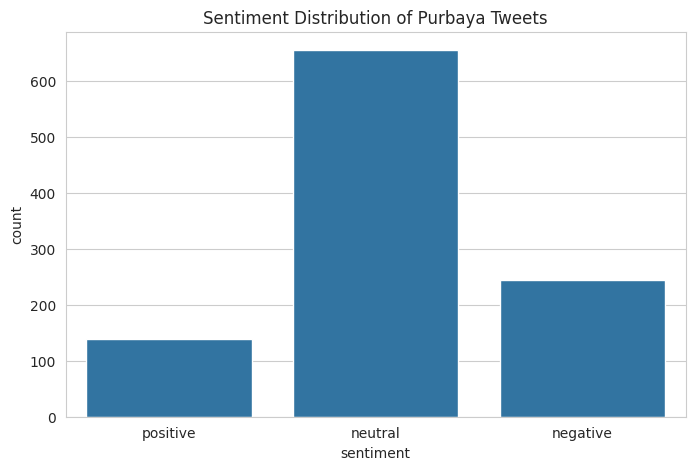

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(8, 5))
sns.countplot(data=df_sorted, x='sentiment', order=['positive', 'neutral', 'negative'])
plt.title('Sentiment Distribution of Purbaya Tweets')
plt.show()

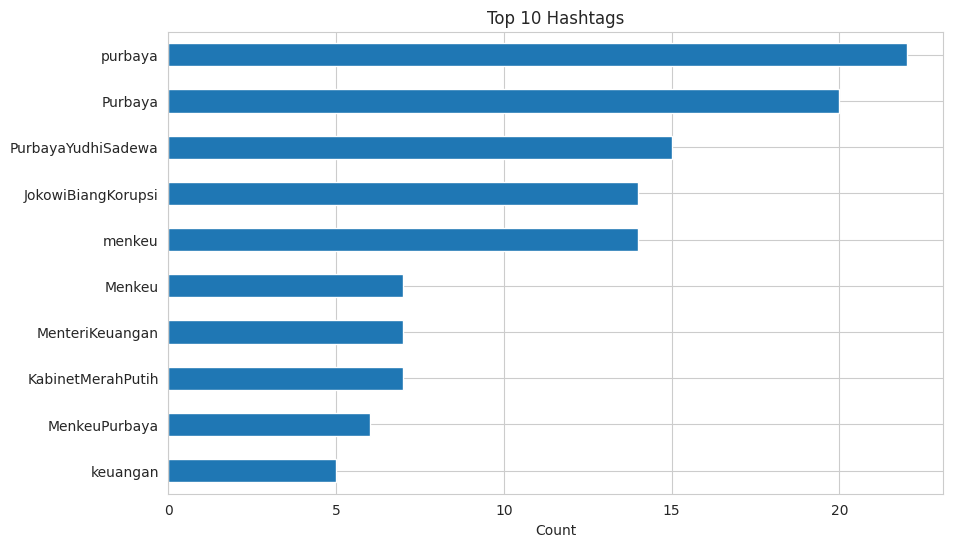

In [15]:
# Top hashtags
all_hashtags = [tag for sublist in df_sorted['hashtags'] for tag in sublist]
hashtag_counts = pd.Series(all_hashtags).value_counts().head(10)

# Check if hashtag_counts is empty before plotting
if not hashtag_counts.empty:
    plt.figure(figsize=(10, 6))
    hashtag_counts.plot(kind='barh')
    plt.title('Top 10 Hashtags')
    plt.xlabel('Count')
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("No hashtags found to display the top 10.")

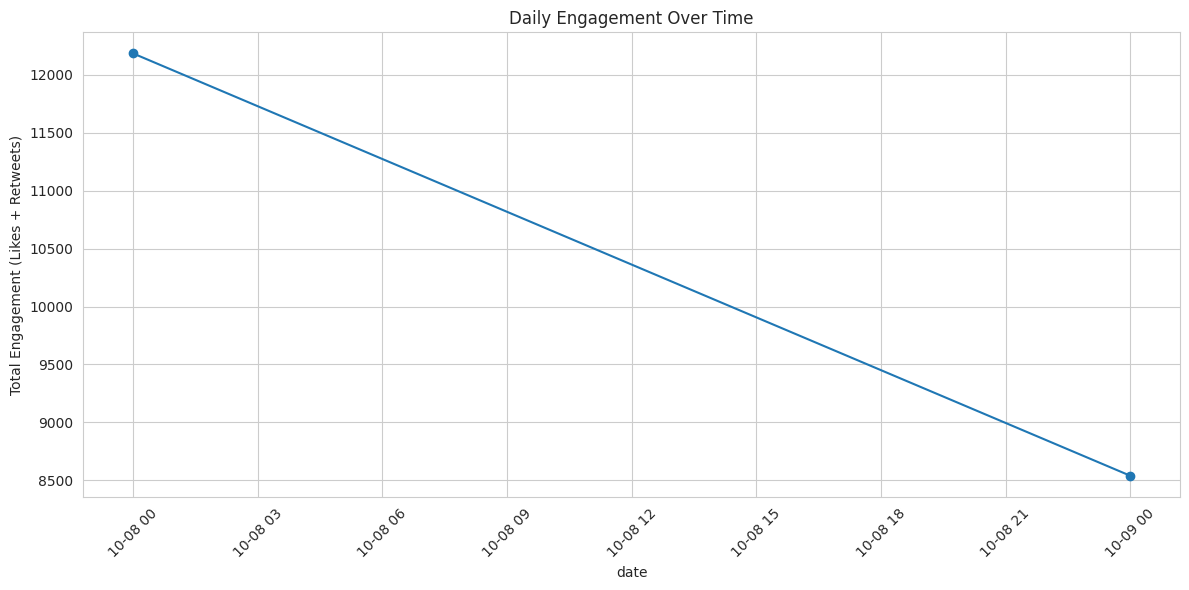

In [16]:
# Engagement over time
df_sorted['date'] = df_sorted['created_at'].dt.date
daily_engagement = df_sorted.groupby('date')['engagement'].sum()
plt.figure(figsize=(12, 6))
daily_engagement.plot(marker='o')
plt.title('Daily Engagement Over Time')
plt.ylabel('Total Engagement (Likes + Retweets)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4448 (\N{HANGUL JUNGSEONG FILLER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


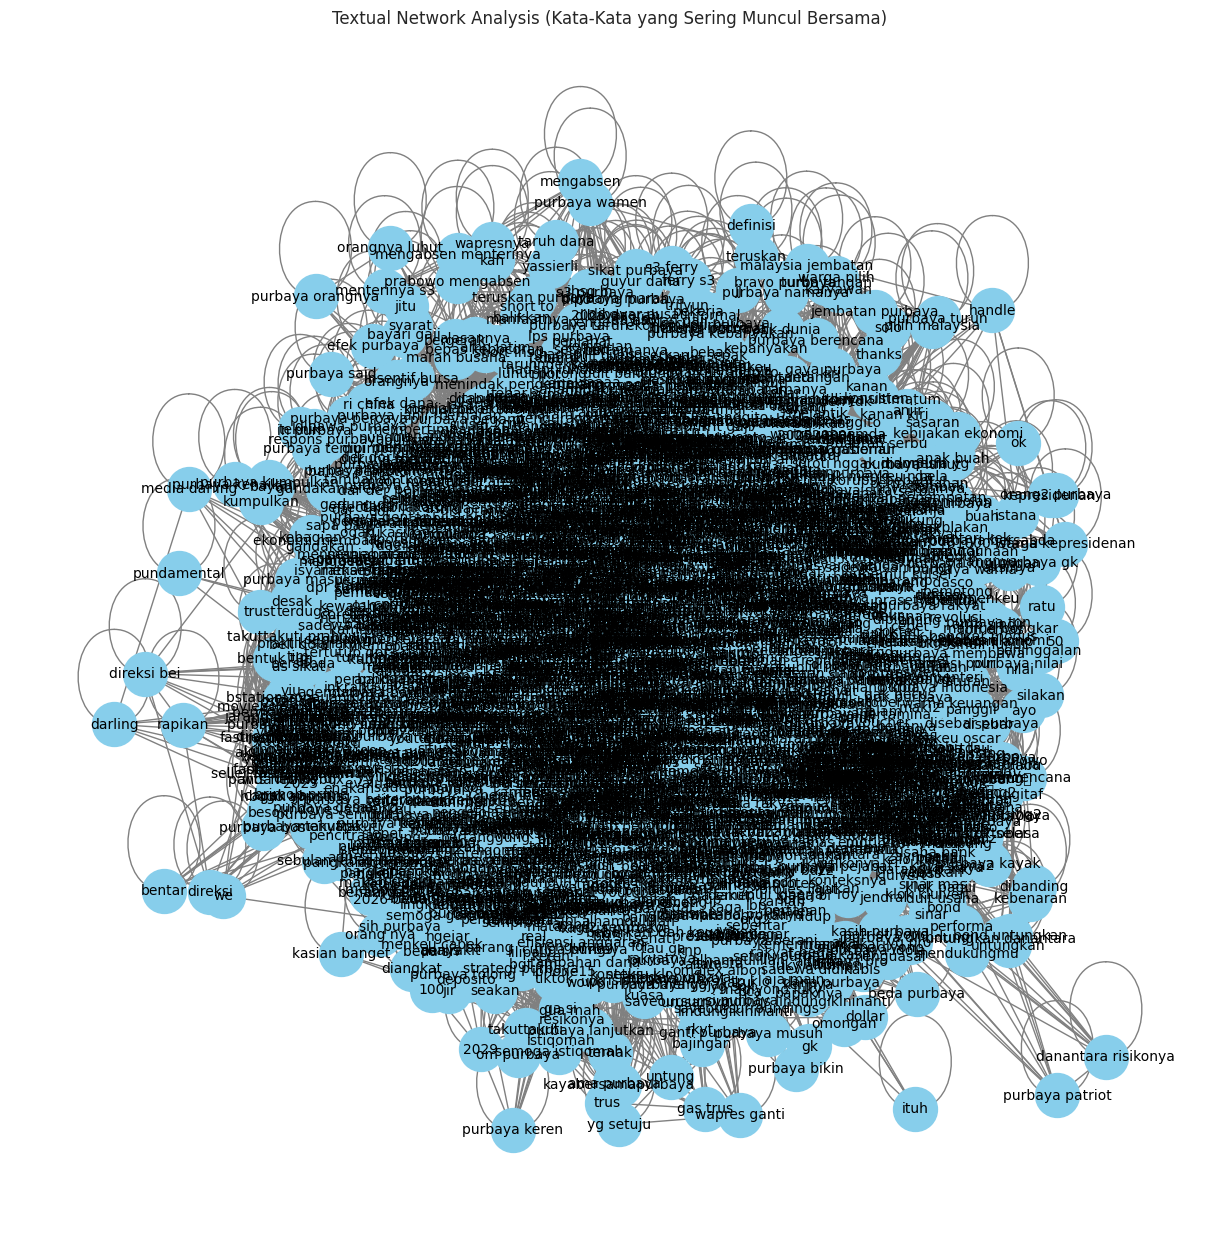

In [17]:
# Install required packages if necessary
!pip install --upgrade networkx scipy nltk scikit-learn

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

# Download stopwords Bahasa Indonesia
try:
    nltk.data.find('corpora/stopwords/indonesian')
except LookupError:
    nltk.download('stopwords')

# 1. Pastikan dataframe dan kolomnya tersedia
if 'df_sorted' in locals() and 'cleaned_text' in df_sorted.columns and not df_sorted['cleaned_text'].dropna().empty:
    texts = df_sorted['cleaned_text'].dropna().astype(str).tolist()

    # 2. Ambil stopwords Bahasa Indonesia
    indonesian_stop_words = stopwords.words('indonesian')

    # 3. Buat vectorizer n-gram 1 dan 2, min_df=2 supaya hanya yang sering muncul
    vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words=indonesian_stop_words, min_df=2)
    X = vectorizer.fit_transform(texts)
    features = vectorizer.get_feature_names_out()

    if X.shape[0] > 0 and X.shape[1] > 0:
        # 4. Matriks co-occurrence
        co_occurrence_matrix = (X.T @ X)
        co_occurrence_matrix.setdiag(0)

        # 5. Buat graph (GANTI ke from_scipy_sparse_array)
        G = nx.from_scipy_sparse_array(co_occurrence_matrix)
        labels = {i: word for i, word in enumerate(features)}
        G = nx.relabel_nodes(G, labels)

        if G.number_of_nodes() > 0:
            plt.figure(figsize=(12, 12))
            pos = nx.spring_layout(G, k=0.3, seed=42)
            nx.draw(
                G, pos,
                with_labels=True,
                node_color='skyblue',
                edge_color='gray',
                node_size=1000,
                font_size=10
            )
            plt.title("Textual Network Analysis (Kata-Kata yang Sering Muncul Bersama)")
            plt.show()
        else:
            print("Graph kosong.")
    else:
        print("Tidak ada kata yang cukup sering muncul untuk divisualisasikan.")
else:
    print("Dataframe 'df_sorted' tidak ditemukan atau kolom 'cleaned_text' kosong.")
